# SQL Injection Detection with Logistic Regression + Character N-grams

This notebook trains a binary classifier to detect SQL injection attacks using:
- **TF-IDF Vectorizer** with character-level n-grams (2-5)
- **Logistic Regression** classifier

### Dataset Structure
```
dataset/
├── train/
│   ├── benign.txt
│   └── malicious.txt
├── val/
│   ├── benign.txt
│   └── malicious.txt
└── test/
    ├── benign.txt
    └── malicious.txt
```

## 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    precision_recall_curve
)
import joblib

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Data Loading

In [2]:
def load_dataset(split: str, base_path: str = "dataset"):
    """
    Load benign and malicious queries from a split (train/val/test).
    Returns X (queries) and y (labels: 0=benign, 1=malicious)
    """
    benign_path = Path(base_path) / split / "benign.txt"
    malicious_path = Path(base_path) / split / "malicious.txt"
    
    with open(benign_path, 'r', encoding='utf-8') as f:
        benign = [line.strip() for line in f if line.strip()]
    
    with open(malicious_path, 'r', encoding='utf-8') as f:
        malicious = [line.strip() for line in f if line.strip()]
    
    X = benign + malicious
    y = [0] * len(benign) + [1] * len(malicious)
    
    print(f"{split.upper()}: {len(benign):,} benign + {len(malicious):,} malicious = {len(X):,} total")
    return X, np.array(y)

# Load all splits
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test, y_test = load_dataset("test")

TRAIN: 800,000 benign + 800,000 malicious = 1,600,000 total
VAL: 100,000 benign + 100,000 malicious = 200,000 total
TEST: 100,000 benign + 100,000 malicious = 200,000 total


### 2.1 Dataset Statistics

     Split  Benign  Malicious   Total  Malicious %
     Train  800000     800000 1600000         50.0
Validation  100000     100000  200000         50.0
      Test  100000     100000  200000         50.0


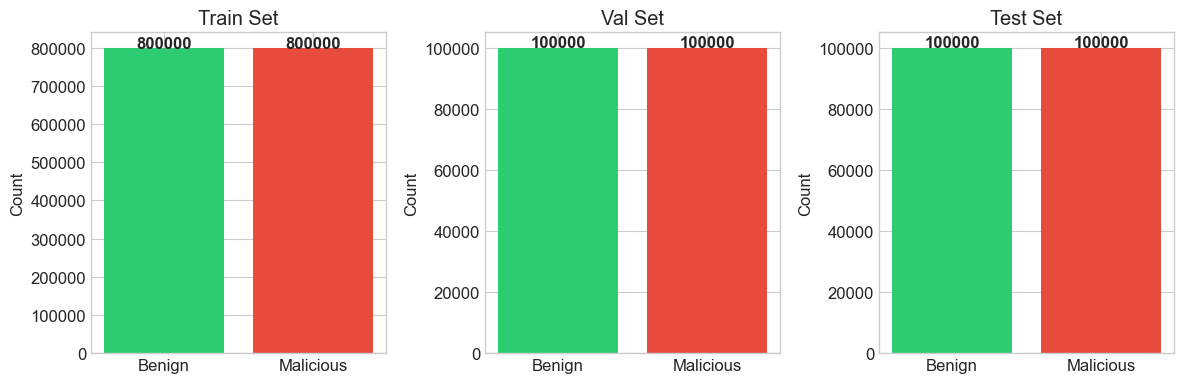

In [3]:
# Dataset summary
stats = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Benign': [sum(y_train == 0), sum(y_val == 0), sum(y_test == 0)],
    'Malicious': [sum(y_train == 1), sum(y_val == 1), sum(y_test == 1)],
    'Total': [len(y_train), len(y_val), len(y_test)]
})
stats['Malicious %'] = (stats['Malicious'] / stats['Total'] * 100).round(1)
print(stats.to_string(index=False))

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, (name, y) in zip(axes, [('Train', y_train), ('Val', y_val), ('Test', y_test)]):
    counts = [sum(y == 0), sum(y == 1)]
    ax.bar(['Benign', 'Malicious'], counts, color=['#2ecc71', '#e74c3c'])
    ax.set_title(f'{name} Set')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts):
        ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Sample Queries

In [4]:
print("=" * 80)
print("BENIGN QUERY EXAMPLES:")
print("=" * 80)
for q in X_train[:3]:
    print(f"\n{q[:200]}..." if len(q) > 200 else f"\n{q}")

print("\n" + "=" * 80)
print("MALICIOUS QUERY EXAMPLES:")
print("=" * 80)
malicious_samples = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1][:3]
for q in malicious_samples:
    print(f"\n{q[:200]}..." if len(q) > 200 else f"\n{q}")

BENIGN QUERY EXAMPLES:

SELECT country_code, COUNT(*) FROM users GROUP BY country_code;

SELECT * FROM orders WHERE order_id = 1 AND user_id = 1 ORDER BY order_date LIMIT 10;

UPDATE cart SET updated_at = '2025-12-09' WHERE cart_id = 89424;

MALICIOUS QUERY EXAMPLES:

sElEcT *, FiRST_VAlue(Name) oveR (paRTItioN By cAteGoRY_Id OrDER BY PRIce) AS ChEapEsT FRom pROducTs ' unioN SELEcT @@versioN--;

REPAIR TABLE sessions 1'/**/OR/**/1=1--;

SHOW TABLES FROM information_schema ' OR 1=1--;


## 3. Feature Extraction: TF-IDF with Character N-grams

In [5]:
# Configure TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    analyzer='char',          # Character-level analysis
    ngram_range=(2, 5),       # 2-grams to 5-grams
    max_features=15000,       # Top 15K features
    lowercase=False,          # Preserve case (SQL keywords)
    sublinear_tf=True,        # Apply log scaling to TF
    min_df=2,                 # Ignore very rare patterns
)

print("Fitting TF-IDF vectorizer on training data...")
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"\nFeature matrix shapes:")
print(f"  Train: {X_train_vec.shape}")
print(f"  Val:   {X_val_vec.shape}")
print(f"  Test:  {X_test_vec.shape}")
print(f"\nVocabulary size: {len(vectorizer.vocabulary_):,} n-grams")

Fitting TF-IDF vectorizer on training data...

Feature matrix shapes:
  Train: (1600000, 15000)
  Val:   (200000, 15000)
  Test:  (200000, 15000)

Vocabulary size: 15,000 n-grams


### 3.1 Top N-gram Features

In [6]:
# Get feature names and their frequencies
feature_names = vectorizer.get_feature_names_out()
tfidf_sums = np.array(X_train_vec.sum(axis=0)).flatten()

# Top 20 most common n-grams
top_idx = tfidf_sums.argsort()[-20:][::-1]
top_ngrams = [(feature_names[i], tfidf_sums[i]) for i in top_idx]

print("Top 20 N-grams by TF-IDF sum:")
for ngram, score in top_ngrams:
    print(f"  '{ngram}': {score:.2f}")

Top 20 N-grams by TF-IDF sum:
  ', ': 35856.06
  '= ': 30890.39
  'er': 30079.61
  ' =': 29968.48
  ' = ': 29930.37
  ' '': 28539.95
  'at': 27279.78
  's ': 26572.35
  'E ': 26501.12
  'T ': 26150.13
  'id': 25957.50
  'us': 25786.14
  '_i': 25739.77
  'se': 25610.11
  '_id': 25363.91
  'or': 24657.35
  ' p': 24281.94
  'SE': 24200.14
  'pr': 23938.37
  'LE': 23553.23


## 4. Model Training: Logistic Regression

In [7]:
# Train Logistic Regression
model = LogisticRegression(
    max_iter=1000,
    C=1.0,                    # Regularization strength
    solver='lbfgs',
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

print("Training Logistic Regression...")
model.fit(X_train_vec, y_train)
print("Training complete!")

# Training accuracy
train_acc = model.score(X_train_vec, y_train)
val_acc = model.score(X_val_vec, y_val)
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Logistic Regression...
Training complete!

Training Accuracy: 0.9982
Validation Accuracy: 0.9973


## 5. Evaluation

### 5.1 Classification Report

In [8]:
# Predictions on test set
y_pred = model.predict(X_test_vec)
y_pred_proba = model.predict_proba(X_test_vec)[:, 1]

# Classification report
print("=" * 60)
print("CLASSIFICATION REPORT (Test Set)")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    100000
   Malicious       1.00      1.00      1.00    100000

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



### 5.2 Confusion Matrix

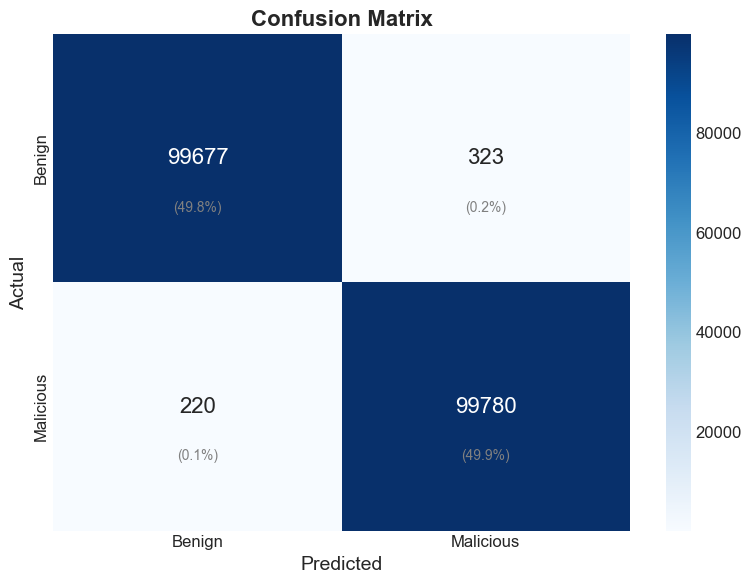


True Negatives (Benign correct): 99677
False Positives (Benign -> Malicious): 323
False Negatives (Malicious -> Benign): 220
True Positives (Malicious correct): 99780


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'],
            annot_kws={'size': 16})
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')

# Add percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / total * 100
        ax.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correct): {tn}")
print(f"False Positives (Benign -> Malicious): {fp}")
print(f"False Negatives (Malicious -> Benign): {fn}")
print(f"True Positives (Malicious correct): {tp}")

### 5.3 ROC Curve

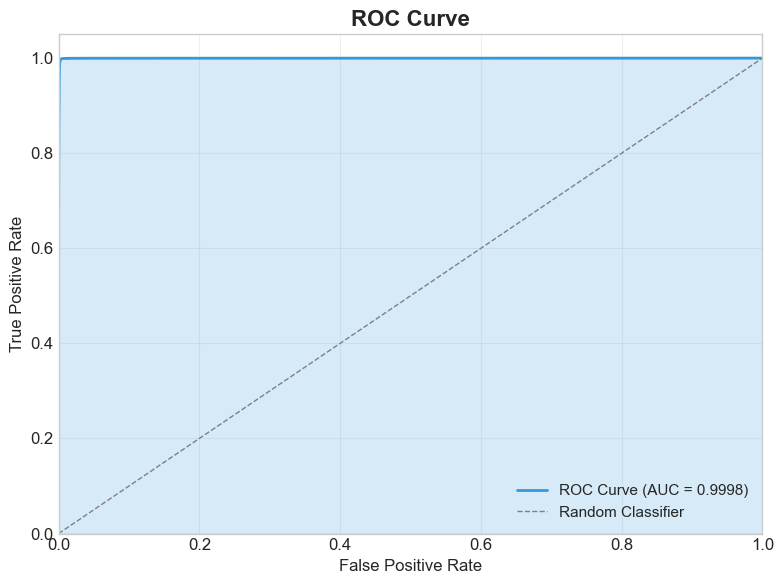

Area Under ROC Curve (AUC): 0.9998


In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='#3498db')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

### 5.4 Precision-Recall Curve

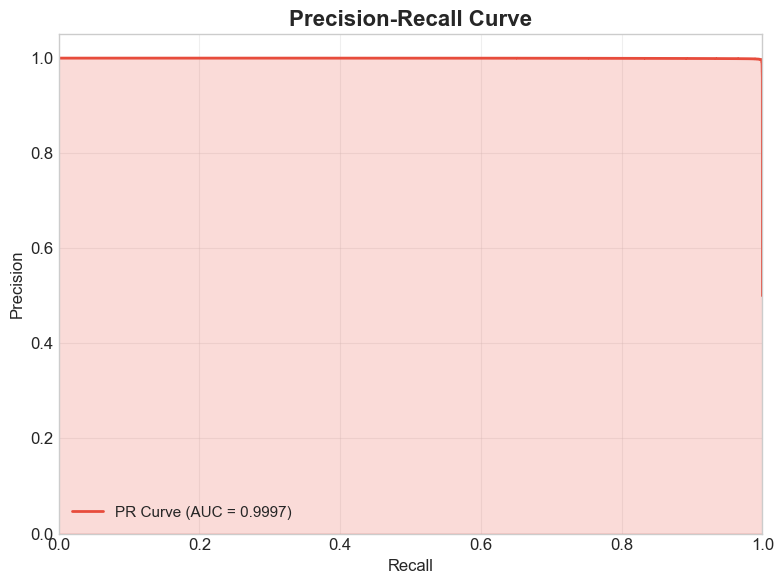

In [11]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall, precision, color='#e74c3c', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
ax.fill_between(recall, precision, alpha=0.2, color='#e74c3c')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=16, fontweight='bold')
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Feature Importance Analysis

In [12]:
# Get feature importances (coefficients)
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'ngram': feature_names,
    'coefficient': coefficients
})

# Top features indicating MALICIOUS (positive coefficients)
top_malicious = feature_importance.nlargest(20, 'coefficient')

# Top features indicating BENIGN (negative coefficients)  
top_benign = feature_importance.nsmallest(20, 'coefficient')

print("Top 20 N-grams indicating MALICIOUS queries:")
print("-" * 40)
for _, row in top_malicious.iterrows():
    print(f"  '{row['ngram']}': {row['coefficient']:.4f}")

print("\nTop 20 N-grams indicating BENIGN queries:")
print("-" * 40)
for _, row in top_benign.iterrows():
    print(f"  '{row['ngram']}': {row['coefficient']:.4f}")

Top 20 N-grams indicating MALICIOUS queries:
----------------------------------------
  '--': 28.1643
  ''#': 24.8971
  '-'': 21.8003
  '/*': 20.4719
  ''#'': 19.9804
  '#'': 19.5100
  '--'': 19.4096
  '*/': 18.4779
  '**': 17.5093
  '**/': 17.5093
  '/**': 17.5093
  '/**/': 17.5093
  '-;': 16.7387
  '#;': 16.2794
  '; ': 15.7083
  '1=': 14.9338
  '--;': 14.4983
  '' ': 14.0547
  'OR ': 13.6285
  'OR': 13.6234

Top 20 N-grams indicating BENIGN queries:
----------------------------------------
  '0;': -6.5909
  'SET ': -5.1253
  'ET ': -5.0705
  'SET @': -5.0067
  'ET @': -4.9934
  'SET': -4.7643
  ', ': -4.7318
  'd', ': -4.7279
  'd',': -4.6923
  ' FROM': -4.5867
  '5;': -4.5165
  ' FRO': -4.4466
  'ET': -4.3648
  ' OFFS': -4.3628
  'FSET ': -4.3615
  ' OFF': -4.3568
  ' OF': -4.3460
  'OFFSE': -4.3282
  'FFSET': -4.3278
  'OFFS': -4.3266


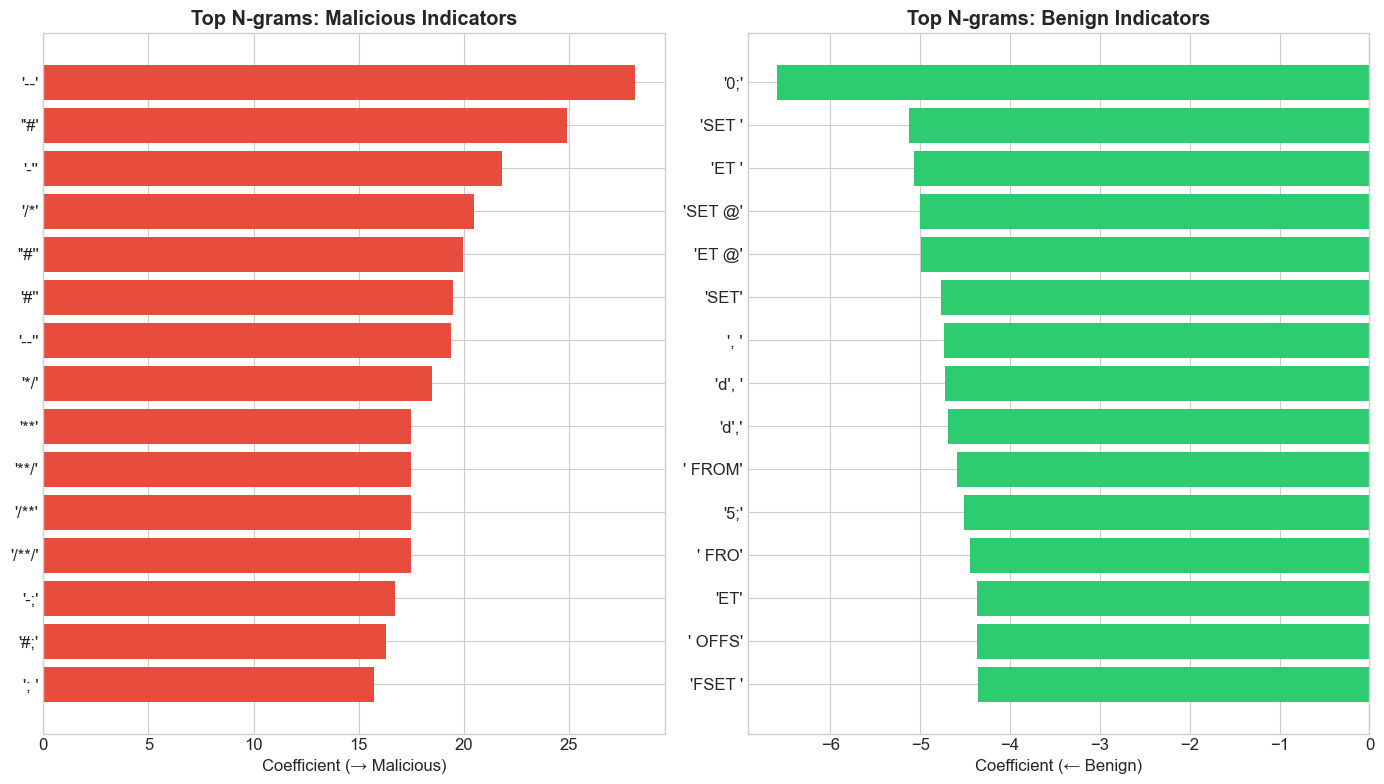

In [13]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Malicious indicators
ax1 = axes[0]
top_mal = feature_importance.nlargest(15, 'coefficient')
ax1.barh(range(len(top_mal)), top_mal['coefficient'], color='#e74c3c')
ax1.set_yticks(range(len(top_mal)))
ax1.set_yticklabels([f"'{n}'" for n in top_mal['ngram']])
ax1.invert_yaxis()
ax1.set_xlabel('Coefficient (→ Malicious)')
ax1.set_title('Top N-grams: Malicious Indicators', fontweight='bold')

# Benign indicators
ax2 = axes[1]
top_ben = feature_importance.nsmallest(15, 'coefficient')
ax2.barh(range(len(top_ben)), top_ben['coefficient'], color='#2ecc71')
ax2.set_yticks(range(len(top_ben)))
ax2.set_yticklabels([f"'{n}'" for n in top_ben['ngram']])
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient (← Benign)')
ax2.set_title('Top N-grams: Benign Indicators', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Model & Vectorizer

In [14]:
# Save model and vectorizer
MODEL_PATH = 'sqli_detector_model.joblib'
VECTORIZER_PATH = 'sqli_vectorizer.joblib'

joblib.dump(model, MODEL_PATH)
joblib.dump(vectorizer, VECTORIZER_PATH)

print(f"Model saved to: {MODEL_PATH}")
print(f"Vectorizer saved to: {VECTORIZER_PATH}")

Model saved to: sqli_detector_model.joblib
Vectorizer saved to: sqli_vectorizer.joblib


## 8. Inference Demo

In [15]:
def predict_sqli(query: str) -> dict:
    """Predict if a SQL query is malicious."""
    X = vectorizer.transform([query])
    pred = model.predict(X)[0]
    proba = model.predict_proba(X)[0]
    
    return {
        'query': query[:100] + '...' if len(query) > 100 else query,
        'prediction': 'MALICIOUS' if pred == 1 else 'BENIGN',
        'confidence': max(proba) * 100,
        'benign_prob': proba[0] * 100,
        'malicious_prob': proba[1] * 100
    }

# Test examples
test_queries = [
    "SELECT * FROM users WHERE id = 5",
    "SELECT * FROM users WHERE id = 1 OR 1=1--",
    "SELECT name, email FROM customers WHERE status = 'active' ORDER BY name",
    "SELECT * FROM products WHERE name = 'laptop' UNION SELECT password FROM users--",
    "INSERT INTO orders (user_id, total) VALUES (42, 99.99)",
    "'; DROP TABLE users; --",
]

print("=" * 80)
print("INFERENCE DEMO")
print("=" * 80)
for q in test_queries:
    result = predict_sqli(q)
    status = "🔴" if result['prediction'] == 'MALICIOUS' else "🟢"
    print(f"\n{status} {result['prediction']} ({result['confidence']:.1f}% confident)")
    print(f"   Query: {result['query']}")

INFERENCE DEMO

🟢 BENIGN (99.7% confident)
   Query: SELECT * FROM users WHERE id = 5

🔴 MALICIOUS (100.0% confident)
   Query: SELECT * FROM users WHERE id = 1 OR 1=1--

🟢 BENIGN (63.7% confident)
   Query: SELECT name, email FROM customers WHERE status = 'active' ORDER BY name

🔴 MALICIOUS (100.0% confident)
   Query: SELECT * FROM products WHERE name = 'laptop' UNION SELECT password FROM users--

🟢 BENIGN (89.1% confident)
   Query: INSERT INTO orders (user_id, total) VALUES (42, 99.99)

🔴 MALICIOUS (100.0% confident)
   Query: '; DROP TABLE users; --


## 9. Summary

In [16]:
# Final summary
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
test_acc = accuracy_score(y_test, y_pred)

print("=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"")
print(f"  Model:             Logistic Regression")
print(f"  Features:          TF-IDF Character N-grams (2-5)")
print(f"  Vocabulary Size:   {len(vectorizer.vocabulary_):,}")
print(f"")
print(f"  Test Accuracy:     {test_acc:.4f}")
print(f"  Precision:         {precision:.4f}")
print(f"  Recall:            {recall:.4f}")
print(f"  F1-Score:          {f1:.4f}")
print(f"  ROC-AUC:           {roc_auc:.4f}")
print(f"")
print("=" * 60)

MODEL PERFORMANCE SUMMARY

  Model:             Logistic Regression
  Features:          TF-IDF Character N-grams (2-5)
  Vocabulary Size:   15,000

  Test Accuracy:     0.9973
  Precision:         0.9973
  Recall:            0.9973
  F1-Score:          0.9973
  ROC-AUC:           0.9998

